<h1> <strong> <center> Model 1: Multinomial Naive Bayes Classification </center> </strong>  </h1> 

Our first model classifies a dataset of Urdu-language text articles using both a manual implementation of Multinomial Naive Bayes (MNB) and Scikit-learn's MNB model. The dataset is split into training, validation, and test sets, and the models are trained and evaluated on these. Metrics like accuracy, precision, recall, F1 score, and confusion matrices are calculated to assess performance. The results from the manual MNB implementation are compared with those from Scikit-learn to ensure consistency.

<h4> 1) Library Imports </h4>

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)

In [28]:
df = pd.read_csv('scraped_data.csv')
df.head()

,gold_label,processed_content,processed_title
0,entertainment,مشہور پنجابی گلوکار اداکار بلجیت دوران معلومات...,بھولنا بھی ۳ گانا پرانا بلجیت کارتک دھماکا دار...
1,entertainment,بلا ووڈ دبنگ خان ممبئی ما شاہ رخ خان پرتعیش رہ...,سلمان خان شاہ رخ خان منت متعلق بڑا انکشاف
2,entertainment,بھارتی فلم ٹی وی معروف اداکارہ نیٹ فلکس مشہور ...,نیلم کوشیاری غیر متوقع سوال پرانا حیران حاضرین...
3,entertainment,شہرت بلندی چھونا بلا ووڈ اداکار پربھاری تنا بڑ...,اداکار پربھاری فلم انڈسٹری بڑا معاہدہ کرلیا
4,entertainment,مشہور بھارتی سیریز ترک مہت الٹنا چشمہ سیٹ پران...,ترک مہت سیٹ پرانا جھگڑا دلیپ جوشی شہ چھوڑنا دھمکی


<h4> 2) Data Splitting </h4>

- This part involves extracting the `gold_label` column from the dataframe to form the labels data.
- It also involves using Scikit-Learn's `train_test_split` function to split the data into Training, Validation, and Testing datasets

In [29]:
X = df.drop('gold_label', axis=1)  
y = df['gold_label'] 

train_size = 0.7
validation_size = 0.10
test_size = 0.20

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size= test_size, random_state= 42, stratify= y)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size= (validation_size / (train_size + validation_size)), random_state= 42, stratify= y_train_validation)

print(f"Training dataset shape: {X_train.shape}, {y_train.shape}")
print(f"Validation dataset shape: {X_validation.shape}, {y_validation.shape}")
print(f"Test dataset shape: {X_test.shape}, {y_test.shape}")

Training dataset shape: (1924, 2), (1924,)
Validation dataset shape: (275, 2), (275,)
Test dataset shape: (550, 2), (550,)


<h4> 3) Vectorizing the Data/Text </h4>

Now that we have completed the preprocessing of our data, we will need to vectorize our sentences - this is necessary to be able to numericalize our inputs before feeding them into our model. 

We will be using the `Bag of Words` approach to vectorize our sentences, which we implemented in PA1_1. <br> 
Here, we create a `BagOfWords` class to vectorize our sentences. This will involve creating

1. A vocabulary from our corpus

2. A mapping from words to indices in our vocabulary

3. A function to vectorize a sentence in the fashion described above

In [30]:
class BagOfWords:
    def __init__(self):
        self.vocabulary = {}
    
    def fit(self, texts):
        for text in texts:
            for word in text.split():
                if word not in self.vocabulary:
                    self.vocabulary[word] = len(self.vocabulary)
    
    def vectorize(self, text):
        vector = np.zeros(len(self.vocabulary), dtype=int) 
        for word in text.split():
            if word in self.vocabulary:
                vector[self.vocabulary[word]] += 1
        return vector

In [31]:
bow = BagOfWords()
bow.fit(X_train['processed_content'])

train_data_vectors = np.array([bow.vectorize(text) for text in X_train['processed_content']])
validation_data_vectors = np.array([bow.vectorize(text) for text in X_validation['processed_content']])
test_data_vectors = np.array([bow.vectorize(text) for text in X_test['processed_content']])

<h4> 4) Implementing the Naive Bayes Machine Learning Model from Scratch </h4>

Now, we implement a manual version of the Multinomial Naive Bayes (MNB) classifier using two functions. 

1. **`train_MNB` Function**: Computes the class priors and likelihoods for each word in the dataset. It uses Laplace smoothing to handle unseen words and calculates the probabilities based on word frequencies in the training data for each class.
   
2. **`MNB_classifier` Function**: Uses the computed priors and likelihoods to classify new data. It calculates the log probabilities of each class for a given input and assigns the class with the highest probability.

In [32]:
import numpy as np

def train_MNB(X, y):
    """
    Train a Multinomial Naive Bayes model.
    """
    classes, counts = np.unique(y, return_counts=True)
    num_classes = len(classes)
    priors = counts / len(y)
    num_features = X.shape[1]
    likelihoods = np.zeros((num_classes, num_features))

    for i, class_label in enumerate(classes):
        X_class = X[y == class_label]
        word_count = X_class.sum(axis=0)
        likelihoods[i, :] = (word_count + 1) / (word_count.sum() + num_features)  # Laplace smoothing

    likelihoods += 1e-10  # To avoid numerical stability issues
    return priors, likelihoods, classes

def MNB_classifier(X, class_priors, likelihoods, classes):
    """
    Predict labels for given data using a trained MNB model.
    """
    log_probabilities = np.zeros((X.shape[0], len(classes)))

    for i in range(len(classes)):
        log_prior = np.log(class_priors[i])
        log_likelihood = np.log(likelihoods[i, :])
        log_probabilities[:, i] = log_prior + np.dot(X, log_likelihood)

    return classes[np.argmax(log_probabilities, axis=1)]

def bootstrap_sample(X, y):
    """
    Generate a bootstrap sample from X and y.
    """
    n_samples = X.shape[0]
    indices = np.random.randint(0, n_samples, n_samples)
    return X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices], y.iloc[indices] if isinstance(y, pd.Series) else y[indices]

def train_bagging_naive_bayes(X, y, n_estimators=10):
    """
    Train a bagging ensemble of Naive Bayes models.
    """
    models = []
    for _ in range(n_estimators):
        X_sample, y_sample = bootstrap_sample(X, y)
        priors, likelihoods, classes = train_MNB(X_sample, y_sample)
        models.append((priors, likelihoods))
    return models, classes

def predict_bagging_naive_bayes(X, models, classes):
    """
    Predict labels using a bagging ensemble of Naive Bayes models.
    """
    n_classes = len(classes)
    predictions = np.zeros((X.shape[0], n_classes))

    for priors, likelihoods in models:
        model_predictions = MNB_classifier(X, priors, likelihoods, classes)
        for i, class_label in enumerate(model_predictions):
            class_index = np.where(classes == class_label)[0][0] 
            predictions[i, class_index] += 1

    return classes[np.argmax(predictions, axis=1)]


<h4> 5) Testing on the Validation Dataset </h4>

Here, we test our model on the validation dataset and assess its performance using the following metrics:
- Accuracy
- Class-wise Precision
- Class-wise Recall
- Macro F1 Score
- Confusion Matrix

In [33]:
# class_priors, likelihoods, classes = train_MNB(train_data_vectors, y_train.values)
# validation_predictions = np.array(MNB_classifier(validation_data_vectors, class_priors, likelihoods, classes))
# validation_actual = y_validation.values

n_estimators = 1000
bagging_models, bagging_classes = train_bagging_naive_bayes(train_data_vectors, y_train, n_estimators)

In [34]:
def make_heat_map(confusion_matrix, title):
  plt.figure(figsize=(12, 6))
  sns.heatmap(confusion_matrix, fmt="d", annot= True, cmap= "Blues", cbar= True)
  plt.title(title)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")
  plt.show()

def evaluate(y_actual, y_predicted, class_labels):
    accuracy = accuracy_score(y_actual, y_predicted)
    print(f"Accuracy: {accuracy * 100:.2f}%\n")
    
    print("Classification Report:")
    print(classification_report(y_actual, y_predicted, target_names=list(map(str, class_labels))))
    
    cm = confusion_matrix(y_actual, y_predicted, labels=class_labels)
    make_heat_map(cm, "Confusion Matrix")


Accuracy: 95.64%

Classification Report:
                    precision    recall  f1-score   support

          business       1.00      0.96      0.98        54
     entertainment       0.94      1.00      0.97        61
science-technology       0.94      0.91      0.93        34
            sports       0.98      0.98      0.98        63
             world       0.92      0.90      0.91        63

          accuracy                           0.96       275
         macro avg       0.96      0.95      0.95       275
      weighted avg       0.96      0.96      0.96       275



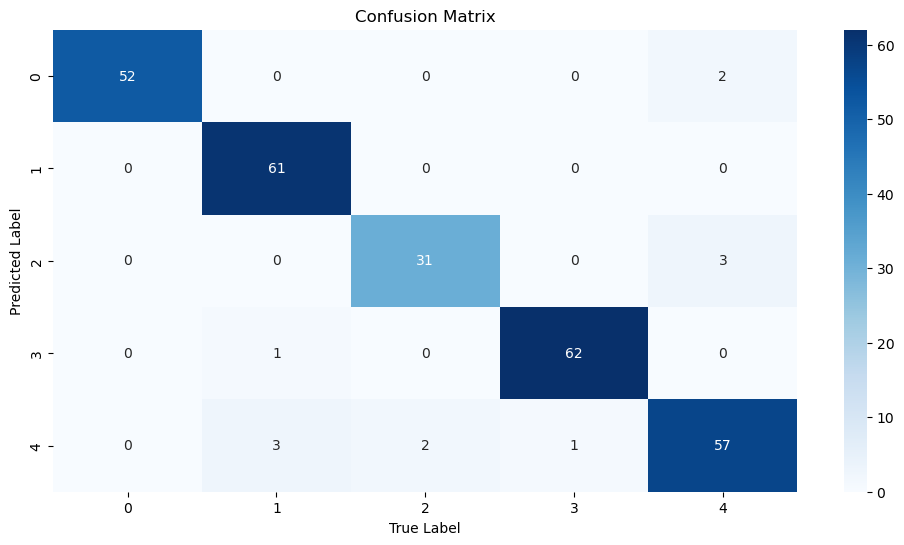

In [35]:
bagging_validation_predictions = predict_bagging_naive_bayes(validation_data_vectors, bagging_models, bagging_classes)
evaluate(y_validation, bagging_validation_predictions, bagging_classes)

<h4> 6) Testing on the Test Dataset </h4>

Here, we test our model on the test dataset and assess its performance using the metrics mentioned above.

In [36]:
# class_priors, likelihoods, classes = train_MNB(train_data_vectors, y_train.values)
# test_predictions = np.array(MNB_classifier(test_data_vectors, class_priors, likelihoods, classes))
# test_actual = y_test.values

Accuracy: 96.55%

Classification Report:
                    precision    recall  f1-score   support

          business       0.98      0.97      0.98       108
     entertainment       0.98      0.98      0.98       121
science-technology       0.94      0.94      0.94        69
            sports       0.99      0.98      0.99       127
             world       0.93      0.94      0.94       125

          accuracy                           0.97       550
         macro avg       0.96      0.96      0.96       550
      weighted avg       0.97      0.97      0.97       550



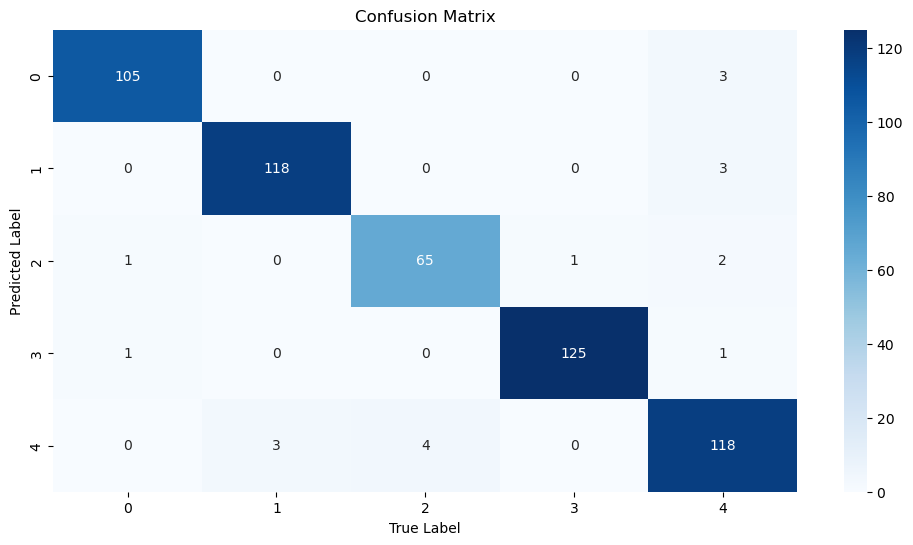

In [37]:
bagging_test_predictions = predict_bagging_naive_bayes(test_data_vectors, bagging_models, bagging_classes)
evaluate(y_test, bagging_test_predictions, bagging_classes)

<h4> 7) Implementing the Naive Bayes Machine Learning Model using Scikit-Learn </h4>

Here we simply implement the Naive Bayes model using the Scikit-Learn library to compare the performance of our own model with that of the standard Scikit-Learn one.

In [38]:
mnb = MultinomialNB()
mnb.fit(train_data_vectors, y_train)

y_validation_predicted_sklearn_MNB = mnb.predict(validation_data_vectors) 
y_test_predicted_sklearn_MNB = mnb.predict(test_data_vectors) 

sklearn_accuracy_validation = accuracy_score(y_validation, y_validation_predicted_sklearn_MNB) 
sklearn_accuracy_test = accuracy_score(y_test, y_test_predicted_sklearn_MNB)  
manual_accuracy_validation = accuracy_score(y_validation, bagging_validation_predictions)  
manual_accuracy_test = accuracy_score(y_test, bagging_test_predictions)  

print(f"Sklearn Multinomial Naive Bayes Accuracy for validation data set: {sklearn_accuracy_validation * 100:.2f}%")
print(f"Manual Multinomial Naive Bayes Accuracy for validation data set: {manual_accuracy_validation * 100:.2f}% \n")
print(f"Sklearn Multinomial Naive Bayes Accuracy for test data set: {sklearn_accuracy_test * 100:.2f}%")
print(f"Manual Multinomial Naive Bayes Accuracy for test data set: {manual_accuracy_test * 100:.2f}%")

Sklearn Multinomial Naive Bayes Accuracy for validation data set: 95.64%
Manual Multinomial Naive Bayes Accuracy for validation data set: 95.64% 

Sklearn Multinomial Naive Bayes Accuracy for test data set: 96.73%
Manual Multinomial Naive Bayes Accuracy for test data set: 96.55%
